In [6]:
from statsmodels.stats.proportion import proportions_ztest
import pandas as pd
import numpy as np
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source
import matplotlib.pyplot as plt
import seaborn as sns
import pydotplus
from IPython.display import Image 
import matplotlib.dates as mdates
from matplotlib_venn import venn2
import warnings
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt
%matplotlib inline

In [98]:
df = pd.read_csv('./Pippin_subsciptions_data.csv')

## Data Preprocessing

In [99]:
df.shape

(94194, 11)

In [100]:
 df.head()

customer_id click_date     platform customer_city customer_state  \
0   1042791267   12/27/17   mobile web   san antonio             tx   
1   1042791268    1/10/18   mobile web      honolulu             hi   
2   1042791269   12/15/17  desktop web       atlanta             ga   
3   1042791270     1/6/18   mobile web      honolulu             hi   
4   1042791271   12/20/17   mobile web         miami             fl   

   urban_flag  credit_card_on_file  student   fav_genre  subscriber  \
0           1                    0        0     hip_hop        True   
1           0                    0        0     hip_hop       False   
2           1                    0        0     hip_hop        True   
3           0                    0        0     hip_hop       False   
4           0                    0        0  indie_rock       False   

   variant_id  
0           1  
1           0  
2           1  
3           0  
4           0

In [101]:
df.dtypes

customer_id             int64
click_date             object
platform               object
customer_city          object
customer_state         object
urban_flag              int64
credit_card_on_file     int64
student                 int64
fav_genre              object
subscriber               bool
variant_id              int64
dtype: object

In [102]:
df['click_date'] =  pd.to_datetime(df['click_date'], format='%m/%d/%y')
df['subscriber'] = 1*df['subscriber'] # change labels for better data manipulation
df['variant_id'] = 1-df['variant_id'] # change labels for familarity

In [103]:
df.head()

customer_id click_date     platform customer_city customer_state  \
0   1042791267 2017-12-27   mobile web   san antonio             tx   
1   1042791268 2018-01-10   mobile web      honolulu             hi   
2   1042791269 2017-12-15  desktop web       atlanta             ga   
3   1042791270 2018-01-06   mobile web      honolulu             hi   
4   1042791271 2017-12-20   mobile web         miami             fl   

   urban_flag  credit_card_on_file  student   fav_genre  subscriber  \
0           1                    0        0     hip_hop           1   
1           0                    0        0     hip_hop           0   
2           1                    0        0     hip_hop           1   
3           0                    0        0     hip_hop           0   
4           0                    0        0  indie_rock           0   

   variant_id  
0           0  
1           1  
2           0  
3           1  
4           1

In [104]:
## check nulls for user_id
df.isnull().sum()

customer_id               0
click_date                0
platform                  0
customer_city            15
customer_state            6
urban_flag                0
credit_card_on_file       0
student                   0
fav_genre              9859
subscriber                0
variant_id                0
dtype: int64

In [105]:
df = df.fillna('null')

In [106]:
df.groupby(['variant_id']).size()

variant_id
0    60362
1    33832
dtype: int64

In [107]:
df.groupby(['variant_id','platform']).size()

variant_id  platform          
0           desktop web           26394
            mobile web            33967
            undefined platform        1
1           mobile web            33830
            undefined platform        2
dtype: int64

In [108]:
df_remove = df[~(df['platform'] == 'desktop web')]

In [109]:
df_remove.groupby(['variant_id','platform']).size()

variant_id  platform          
0           mobile web            33967
            undefined platform        1
1           mobile web            33830
            undefined platform        2
dtype: int64

In [110]:
# df
df.describe()

customer_id    urban_flag  credit_card_on_file       student  \
count  9.419400e+04  94194.000000         94194.000000  94194.000000   
mean   1.042838e+09      0.506911             0.021604      0.300093   
std    2.719161e+04      0.499955             0.145389      0.458301   
min    1.042791e+09      0.000000             0.000000      0.000000   
25%    1.042815e+09      0.000000             0.000000      0.000000   
50%    1.042838e+09      1.000000             0.000000      0.000000   
75%    1.042862e+09      1.000000             0.000000      1.000000   
max    1.042885e+09      1.000000             1.000000      1.000000   

         subscriber    variant_id  
count  94194.000000  94194.000000  
mean       0.072053      0.359174  
std        0.258578      0.479761  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        0.000000      1.000000  
max        1.000000      1.000000

In [111]:
# df after removing desktop web
df_remove.describe()

customer_id    urban_flag  credit_card_on_file       student  \
count  6.780000e+04  67800.000000         67800.000000  67800.000000   
mean   1.042839e+09      0.530664             0.018835      0.303982   
std    2.716285e+04      0.499063             0.135942      0.459978   
min    1.042791e+09      0.000000             0.000000      0.000000   
25%    1.042815e+09      0.000000             0.000000      0.000000   
50%    1.042839e+09      1.000000             0.000000      0.000000   
75%    1.042862e+09      1.000000             0.000000      1.000000   
max    1.042885e+09      1.000000             1.000000      1.000000   

         subscriber    variant_id  
count  67800.000000  67800.000000  
mean       0.069484      0.498997  
std        0.254277      0.500003  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        0.000000      1.000000  
max        1.000000      1.000000

#### The conversion rate is 7.2% and 6.9% after removing desktop web.


## Overview of subscription conversion trends

### Trend by date

In [22]:
def plot_conversion_line(df,col,category = None, val=None):
    df_slice = pd.DataFrame(columns = [col,'control','treatment'])
    for i in df[col].sort_values().unique():
        control = np.mean(df[(df.variant_id == 0) & (df[col] == i)].subscriber)
        treatment = np.mean(df[(df.variant_id == 1) & (df[col] == i)].subscriber)
        dict_ = {col:[i],
        'control':[control],
        'treatment':[treatment]
       }
        df_slice = pd.concat([df_slice,pd.DataFrame(dict_)],ignore_index = True)
    fig, ax = plt.subplots(figsize=(15,5))
    df_slice['weekday'] = df_slice['click_date'].dt.day_name().apply(lambda x:x[0:3])
    ax.plot(df_slice[col],df_slice['control'],label='control')
    ax.plot(df_slice[col],df_slice['treatment'],label = 'treatment')
    ax.legend()
    
    fig.autofmt_xdate()
    ax.set_facecolor('xkcd:black')
    ax.yaxis.label.set_color('white')
    ax.xaxis.label.set_color('white')
       
#     ax.tick_params(axis='x', colors='white')
#     ax.tick_params(axis='y', colors='white')
    
    ax.spines['bottom'].set_color('white')
    ax.spines['top'].set_color('white') 
    ax.spines['right'].set_color('white')
    ax.spines['left'].set_color('white')

    if val is None:
        ax.title.set_text('Subscription Rate')
    else:
        ax.title.set_text(f'Subscription Rate {category} {val}')
        
#     ax.title.set_color('white') 

    for label, x, y in zip(df_slice['weekday'], df_slice['click_date'], df_slice['control']):
        ax.annotate(label, xy = (x, y),fontsize = 12,color = 'white')
    for label, x, y in zip(df_slice['weekday'], df_slice['click_date'], df_slice['treatment']):
        ax.annotate(label, xy = (x, y),fontsize = 12,color = 'white')
        

In [23]:
def group_by(df,category):
    for val in df[category].unique():
        df_plot = df[df[category]==val]
        plot_conversion_line(df_plot,'click_date',category ,val)

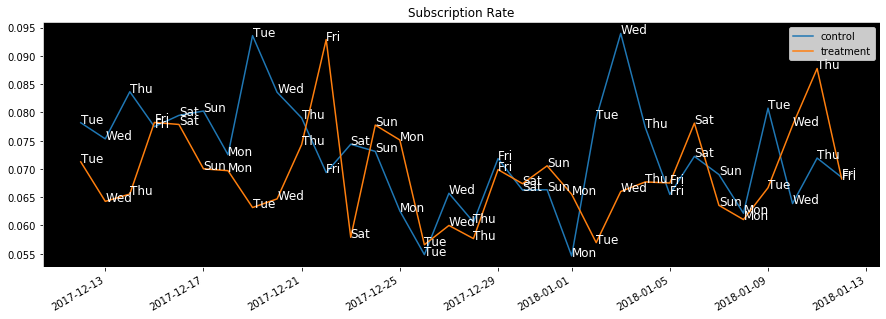

In [26]:
plot_conversion_line(df,'click_date') 

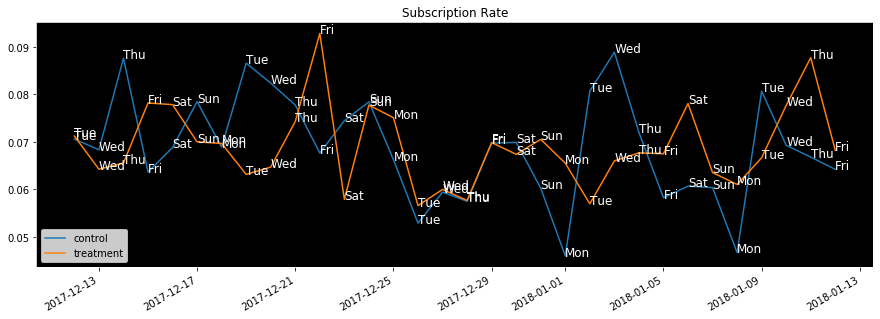

In [27]:
plot_conversion_line(df_remove,'click_date')

### Trend by date by category

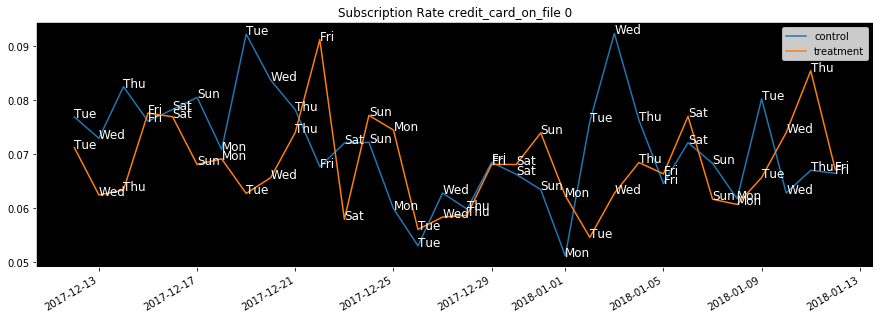

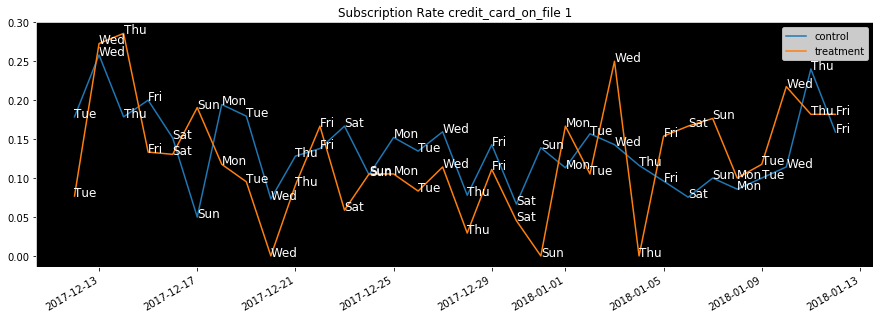

In [29]:
group_by(df,'credit_card_on_file')

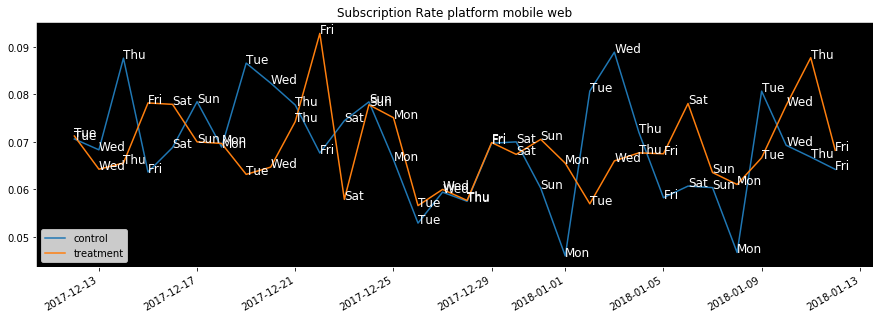

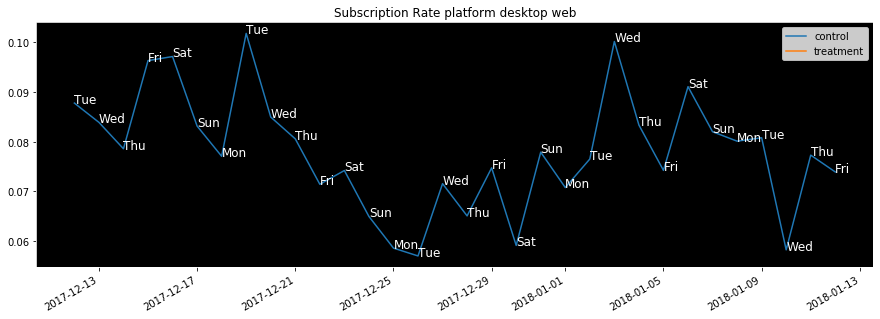

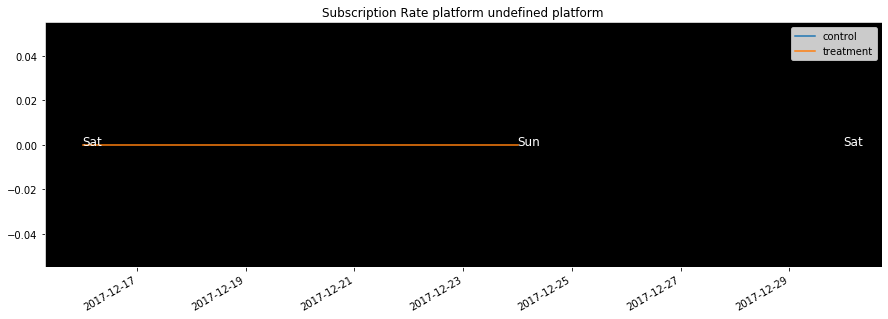

In [30]:
group_by(df,'platform')

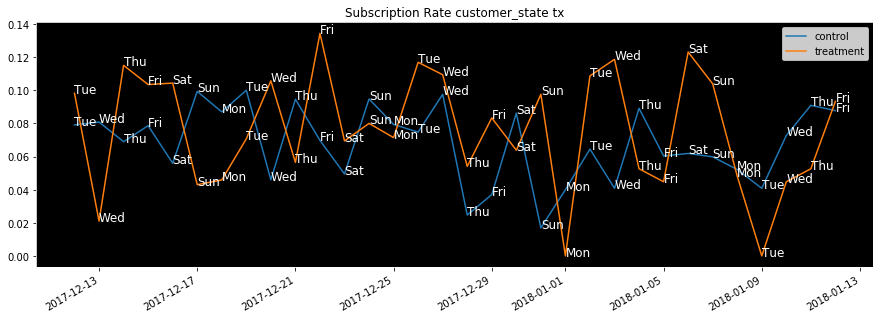

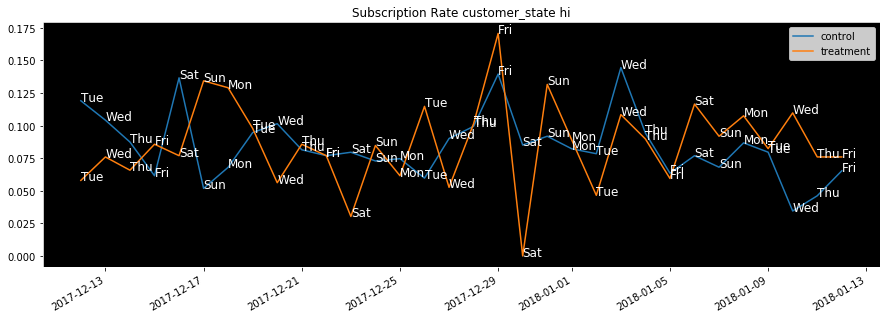

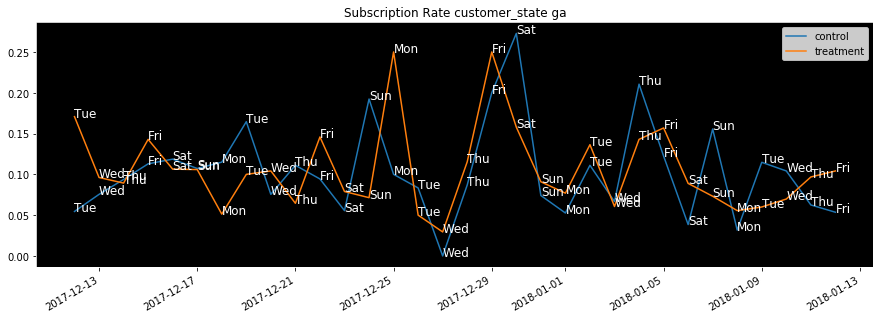

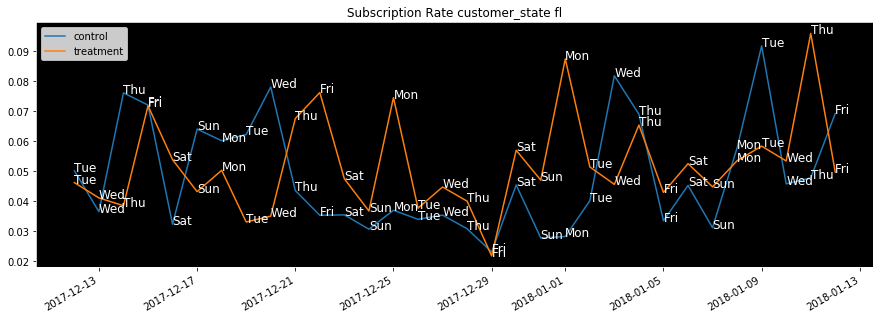

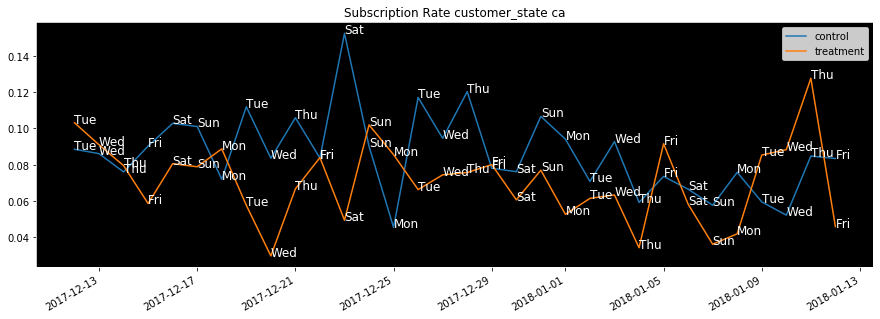

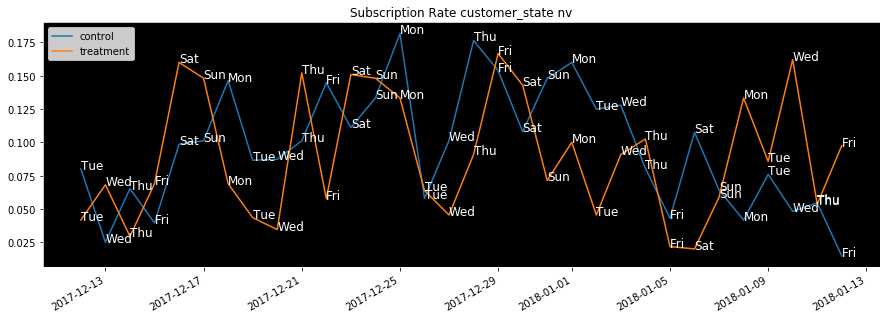

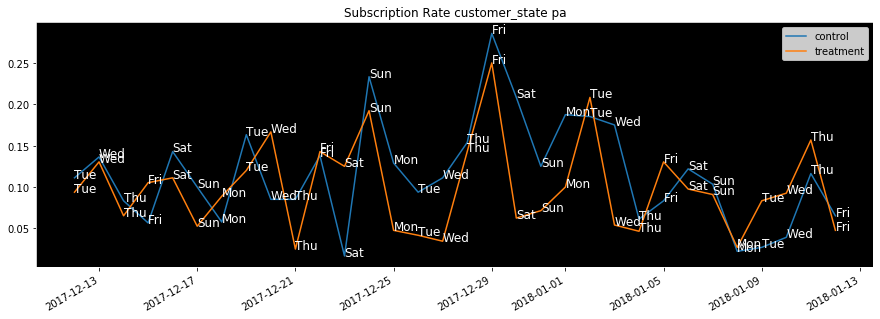

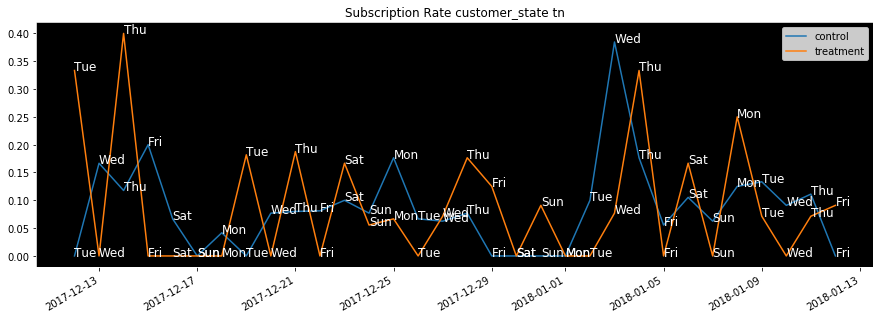

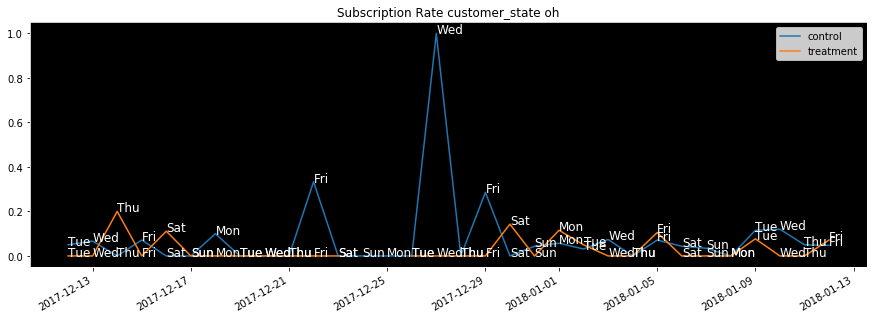

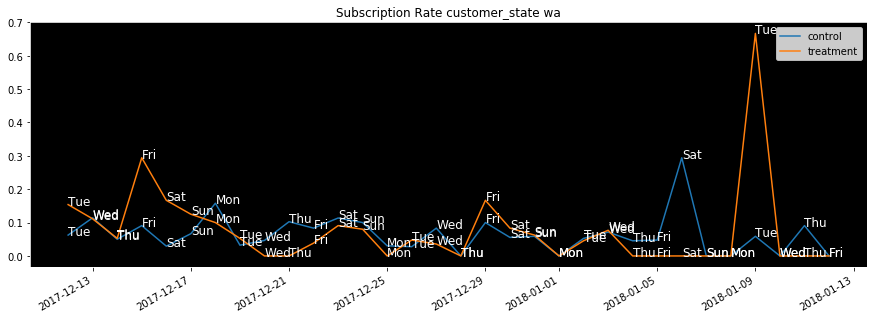

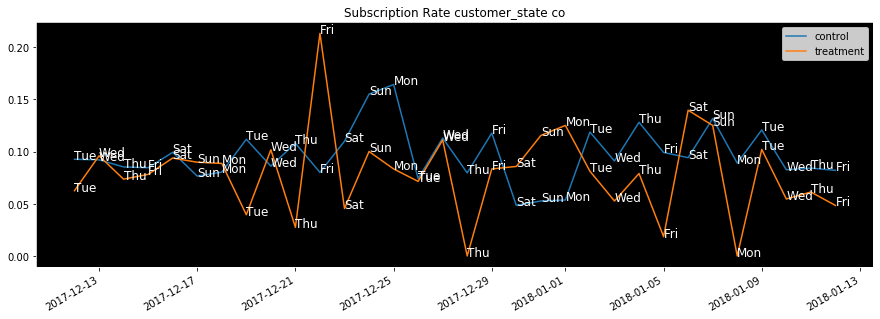

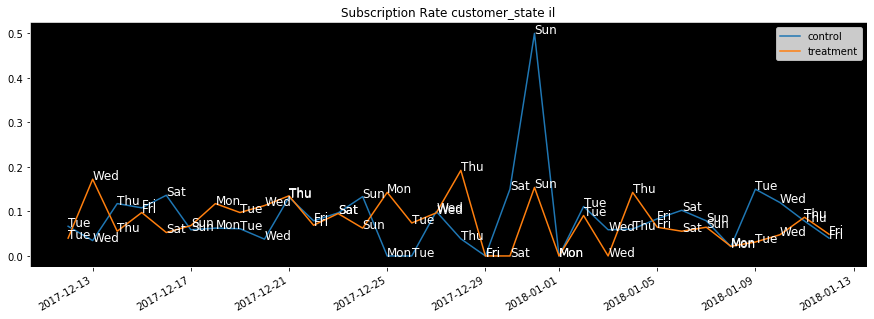

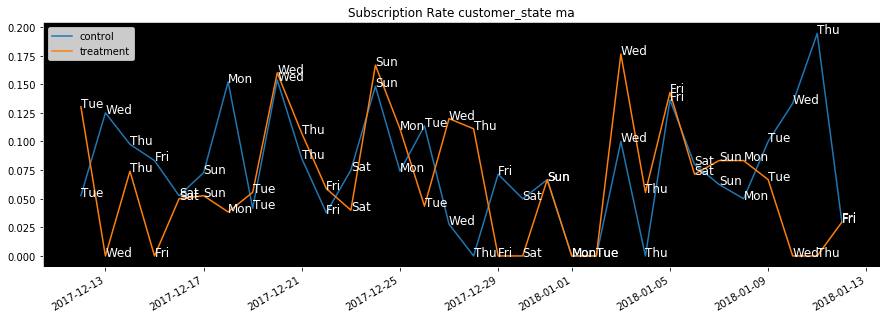

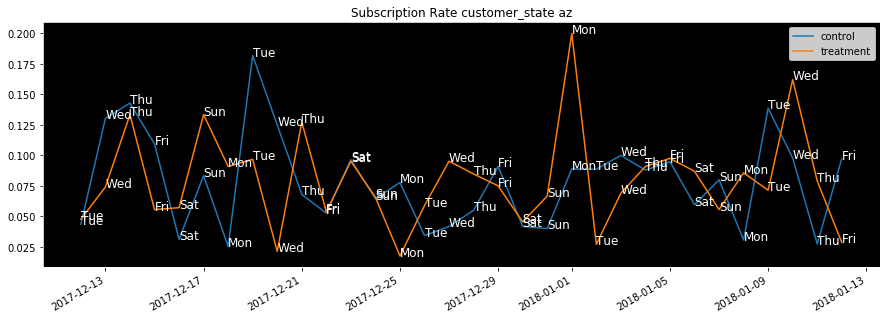

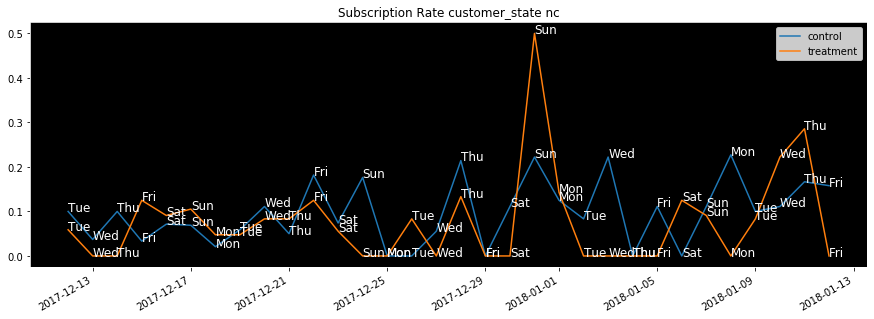

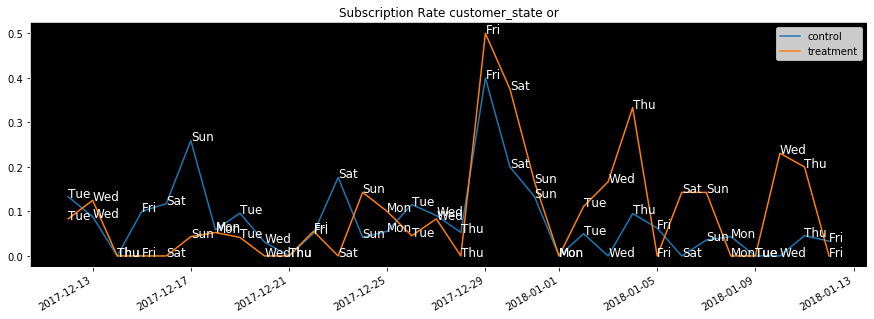

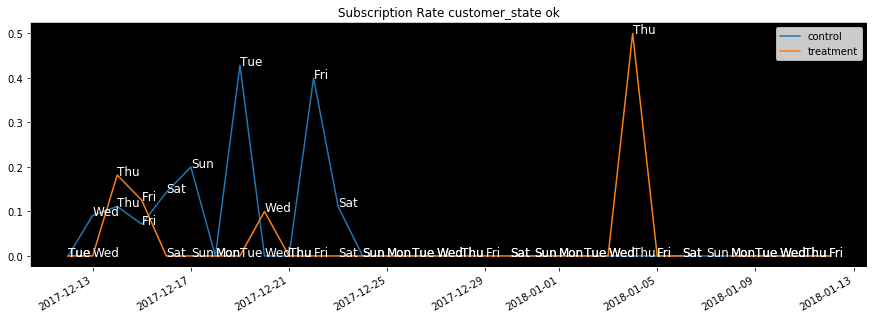

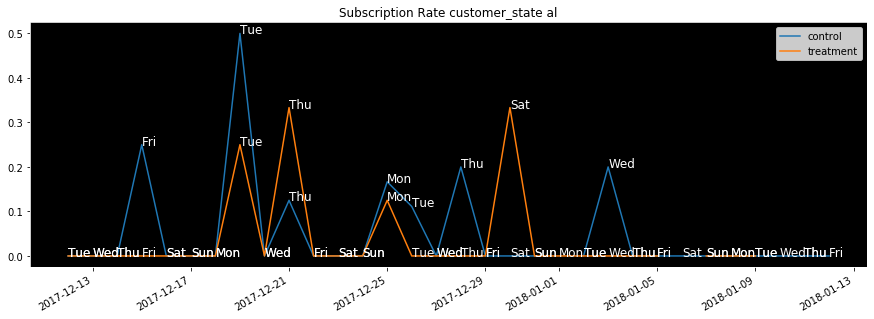

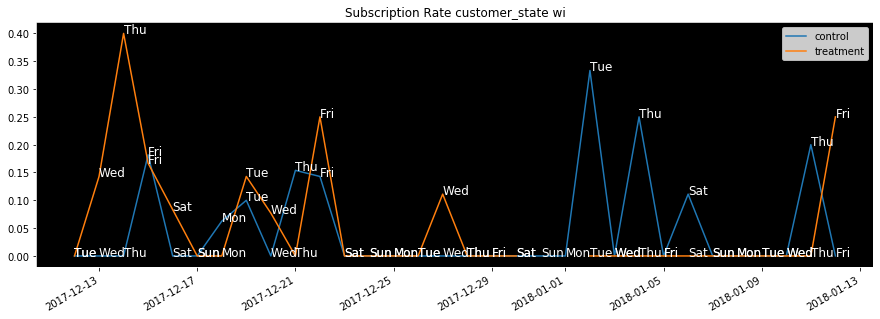

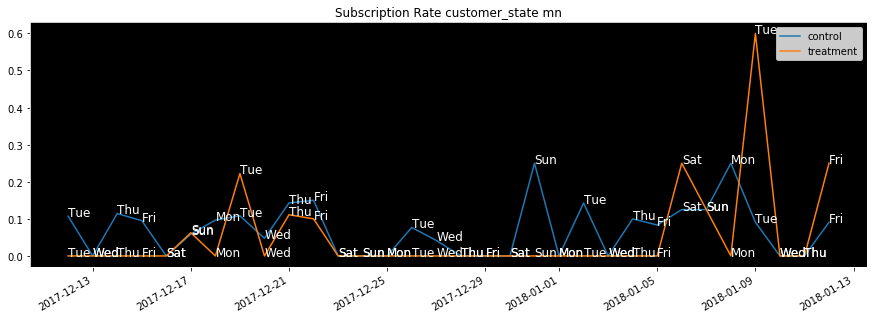

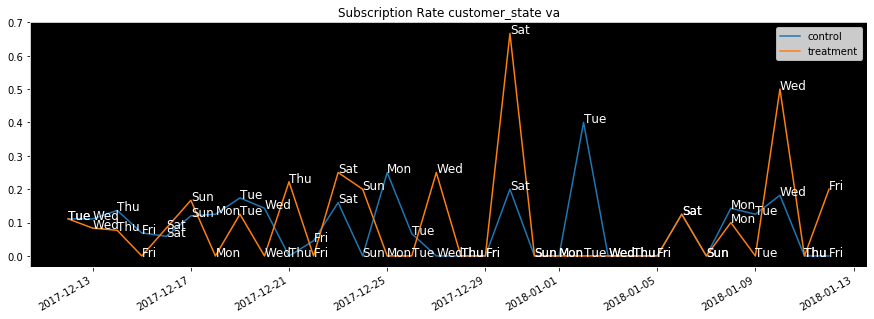

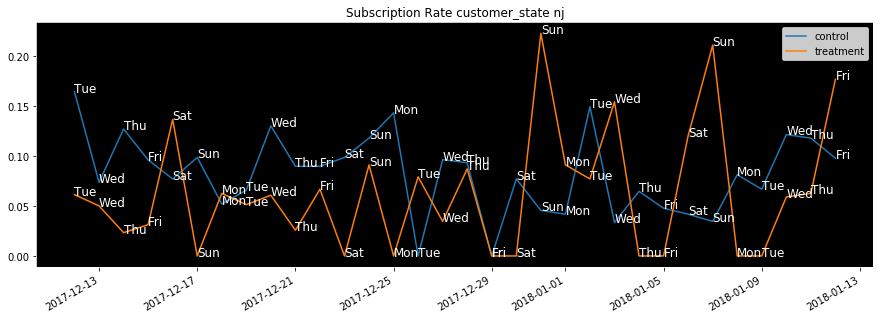

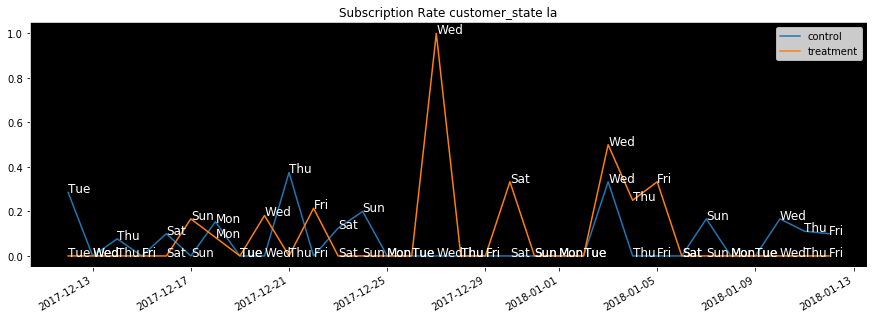

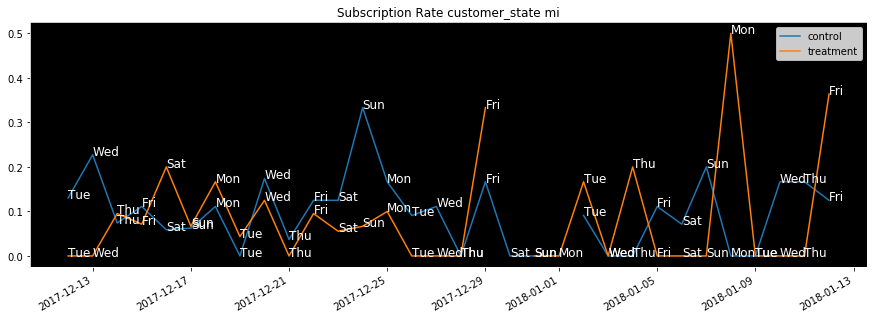

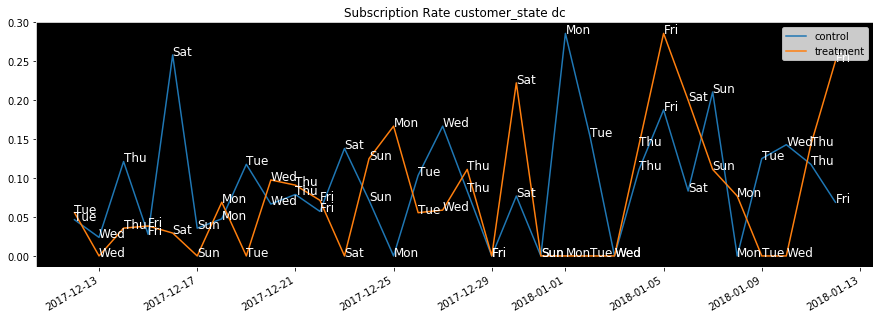

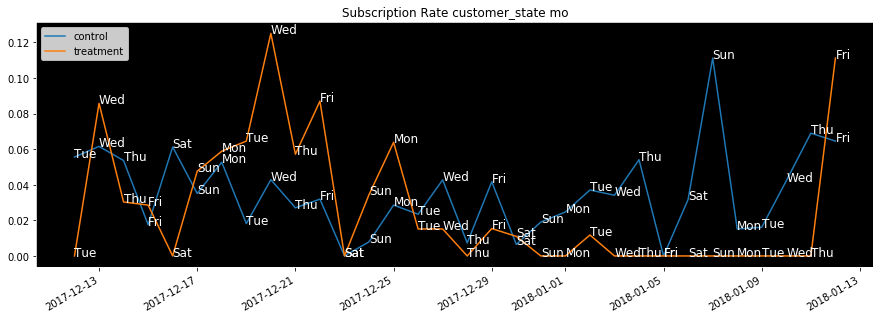

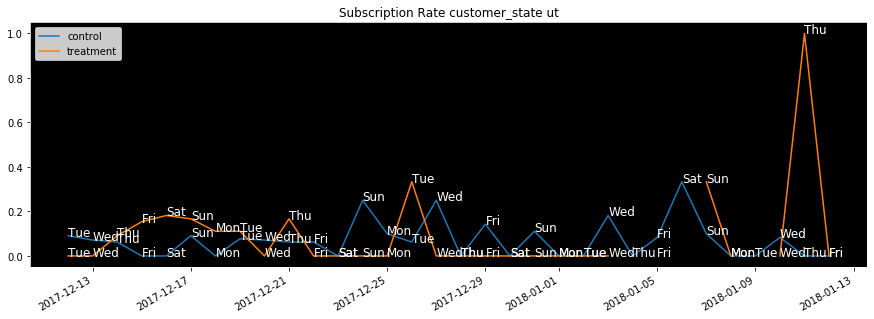

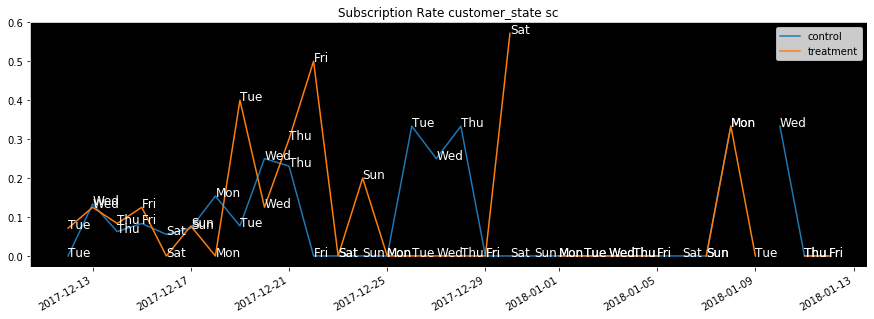

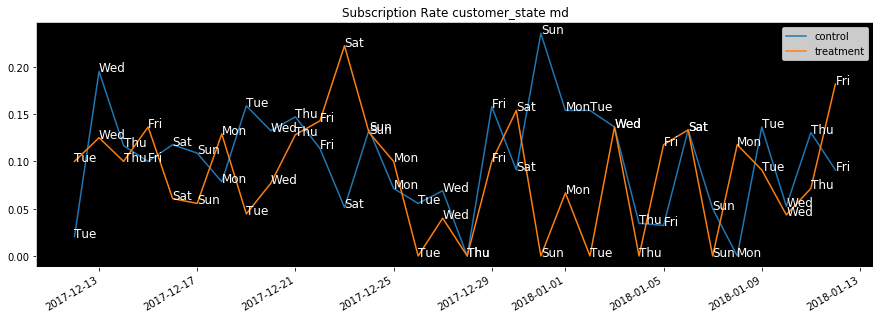

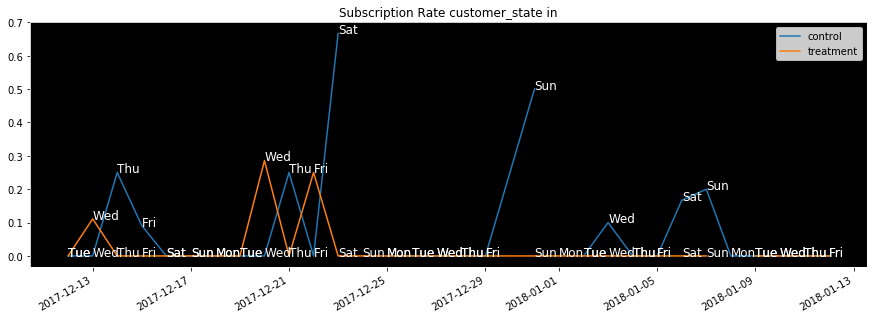

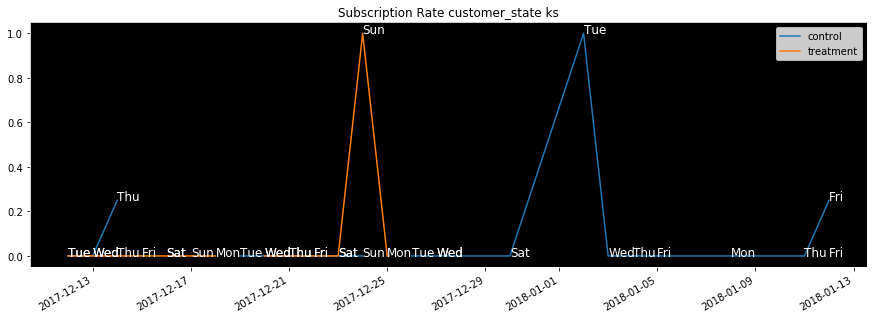

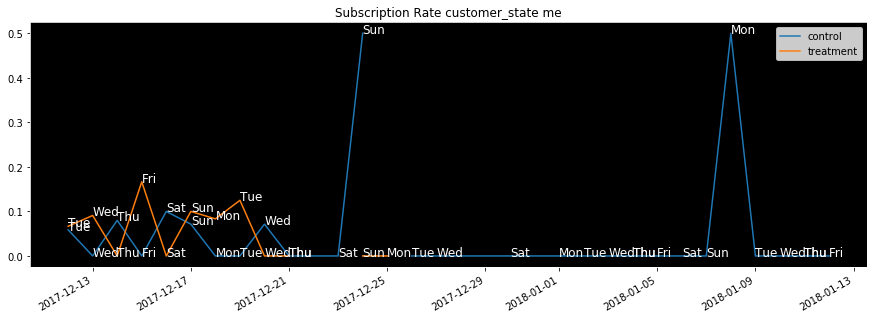

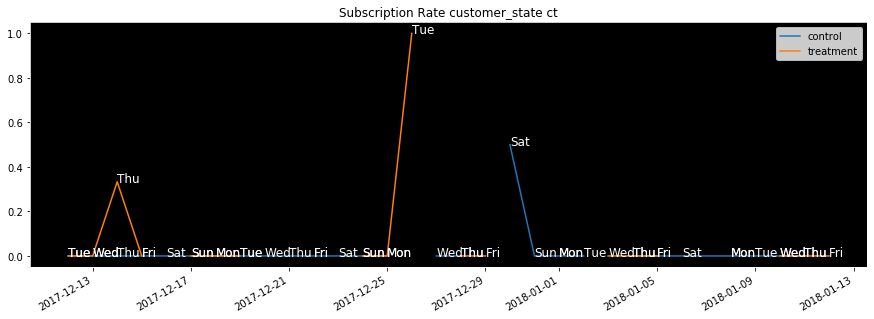

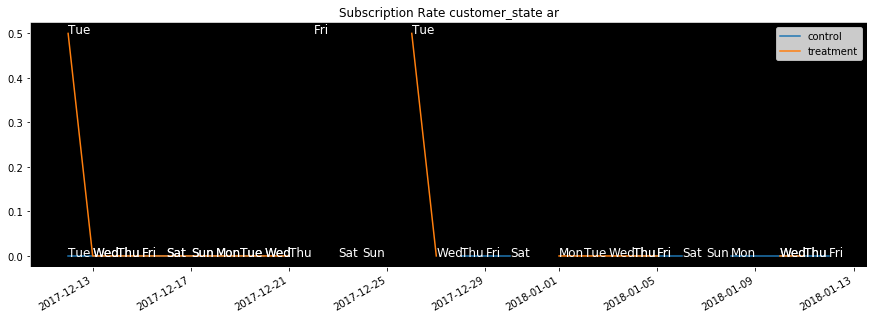

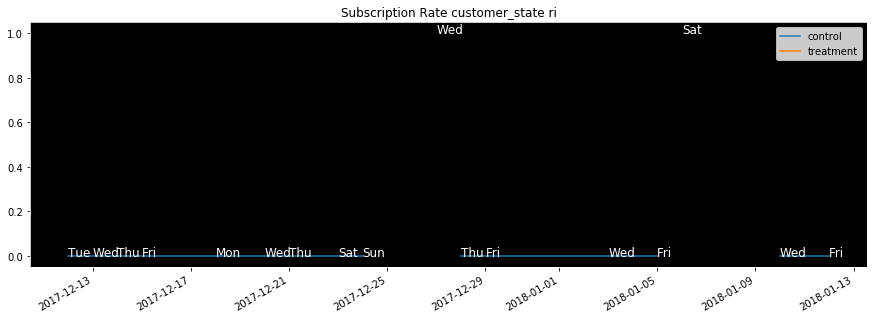

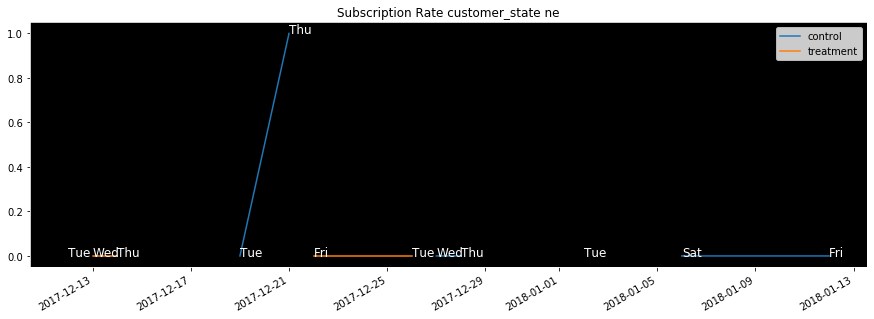

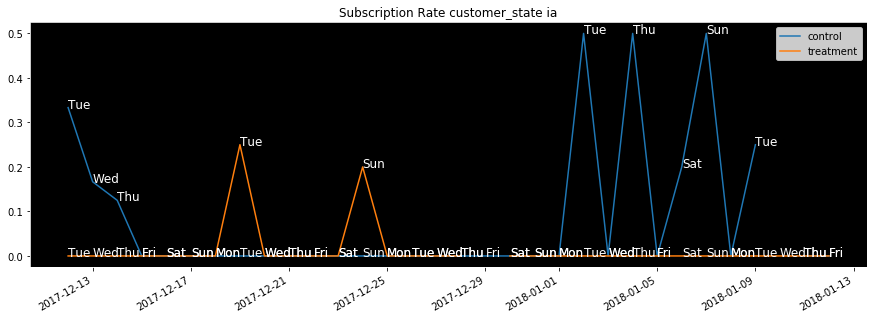

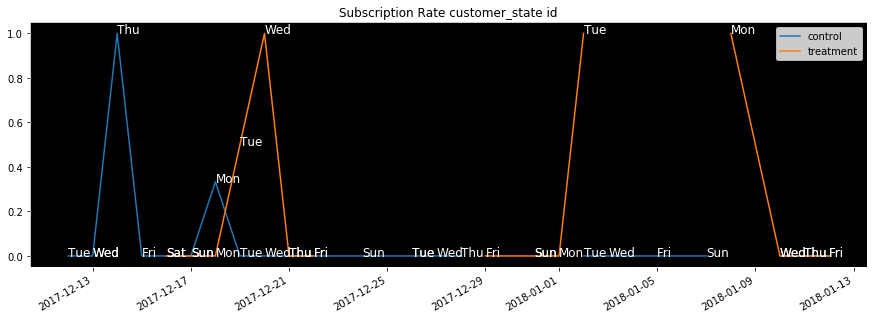

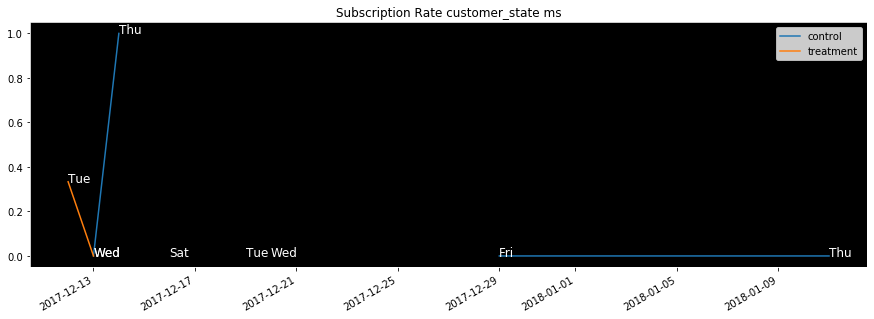

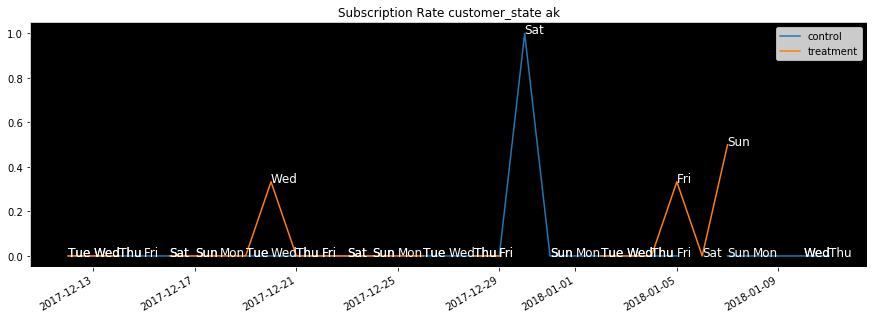

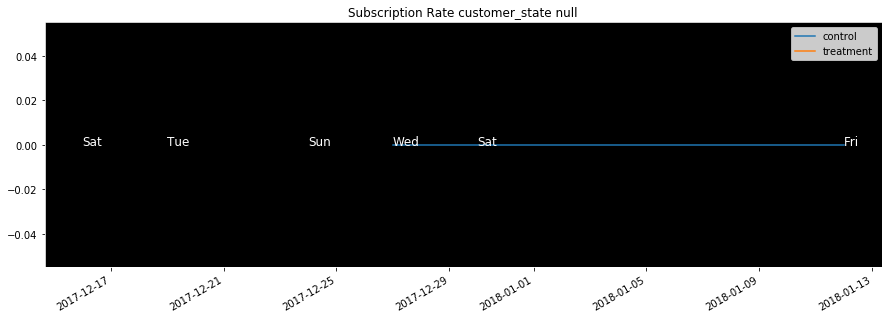

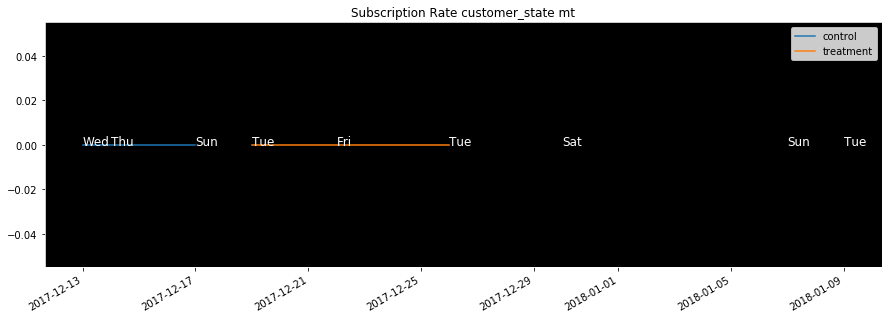

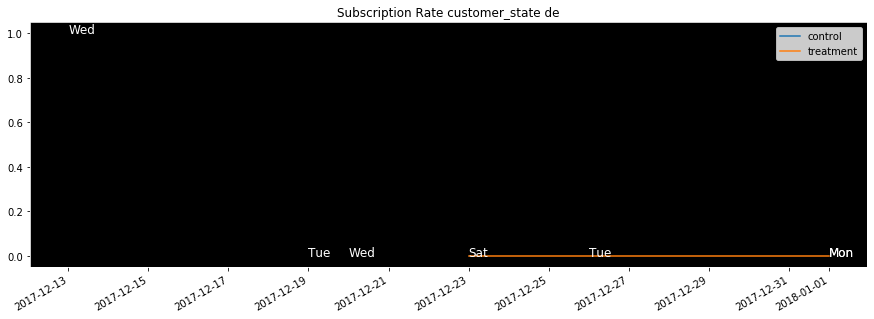

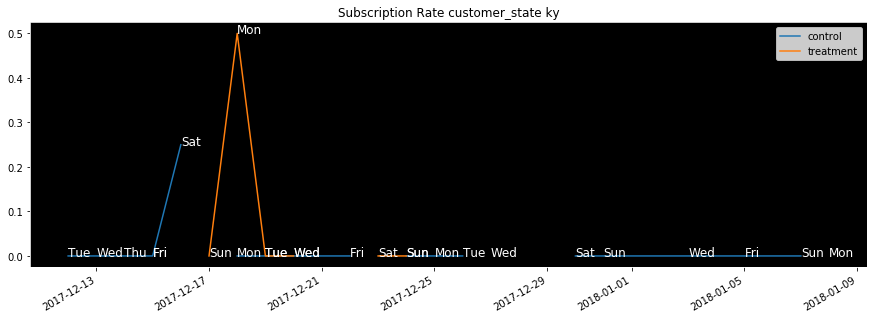

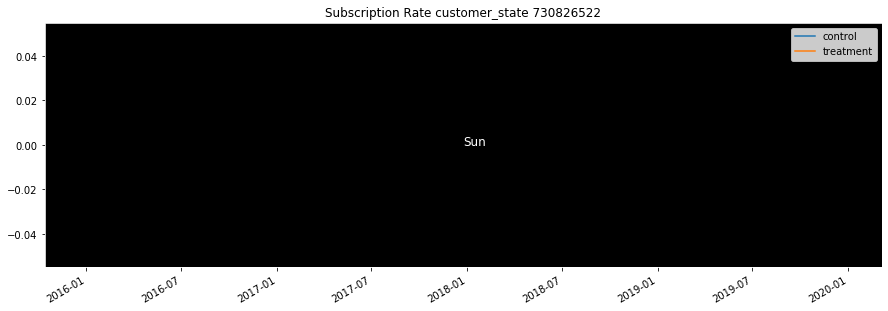

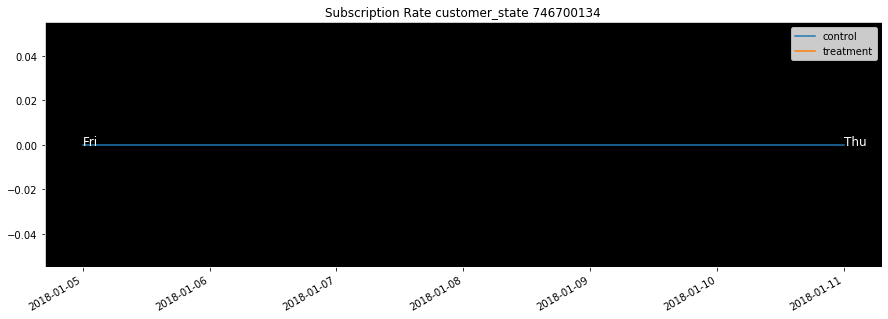

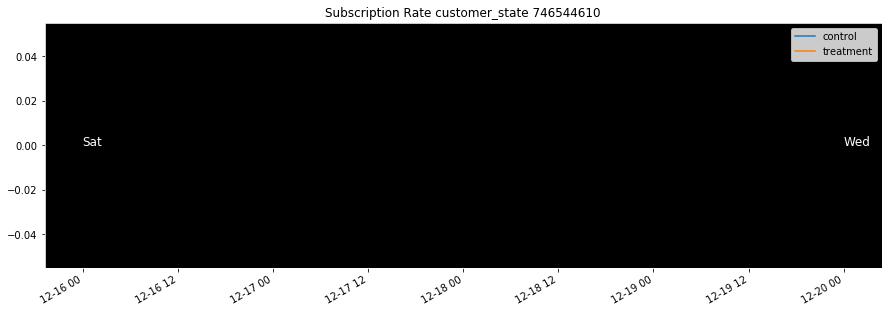

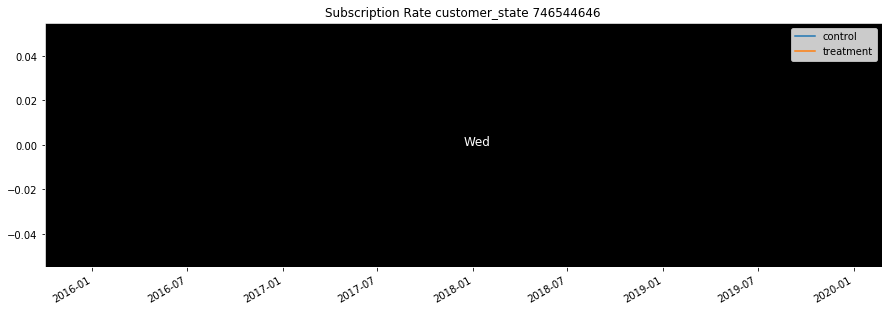

In [31]:
group_by(df,'customer_state')

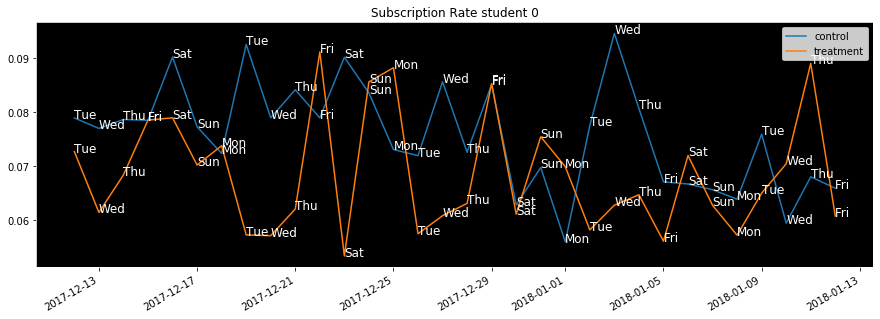

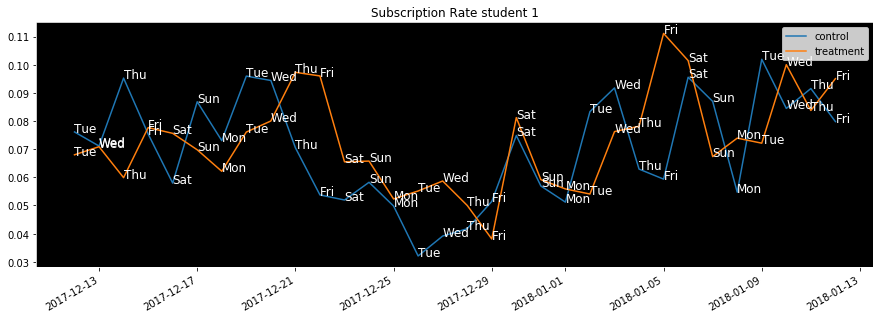

In [32]:
group_by(df,'student')

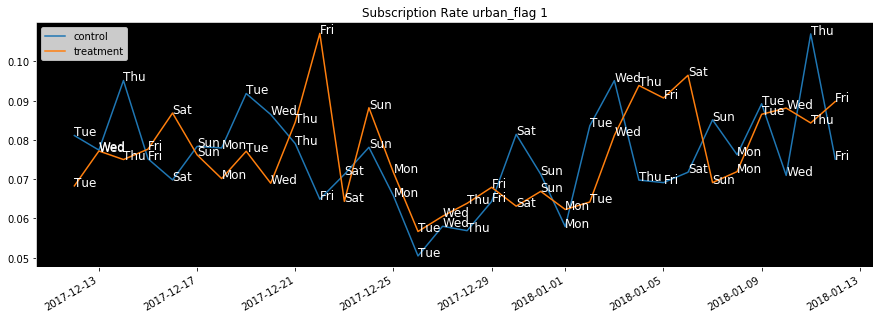

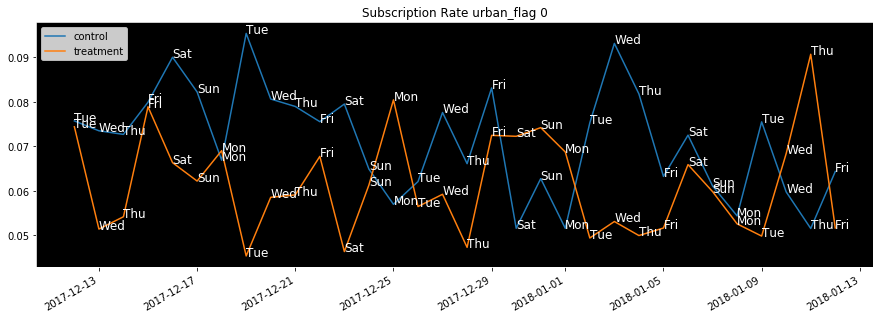

In [33]:
group_by(df,'urban_flag')

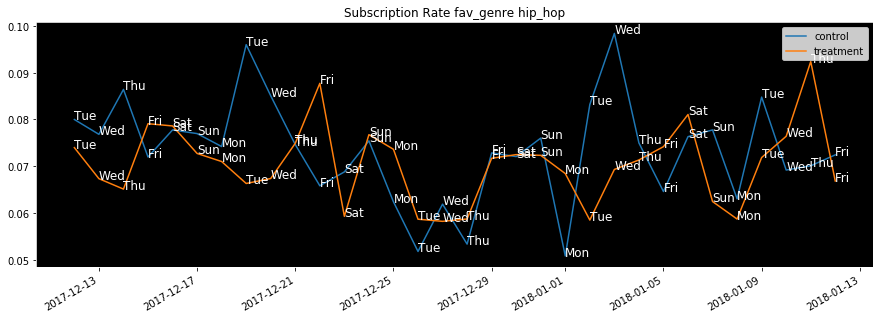

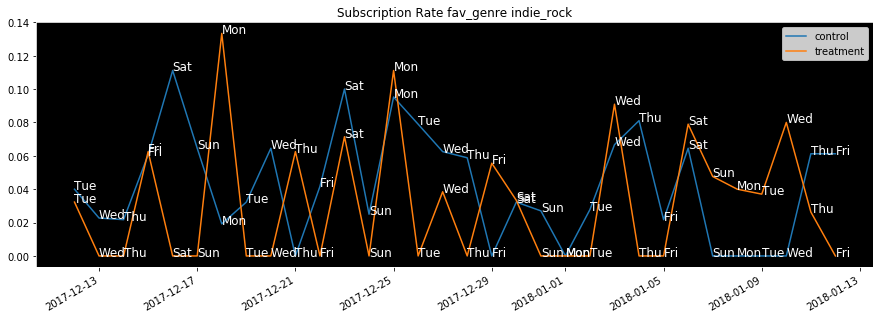

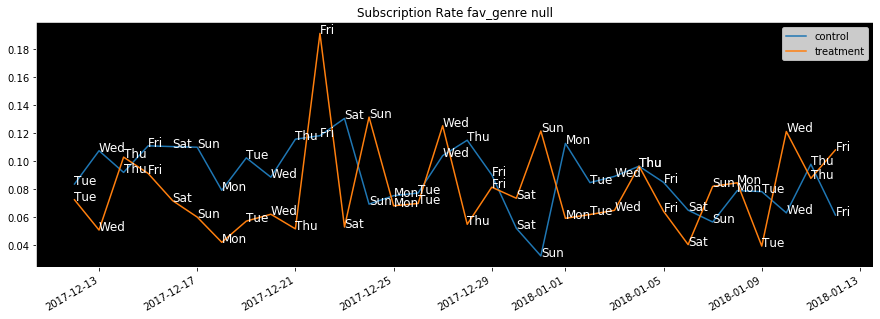

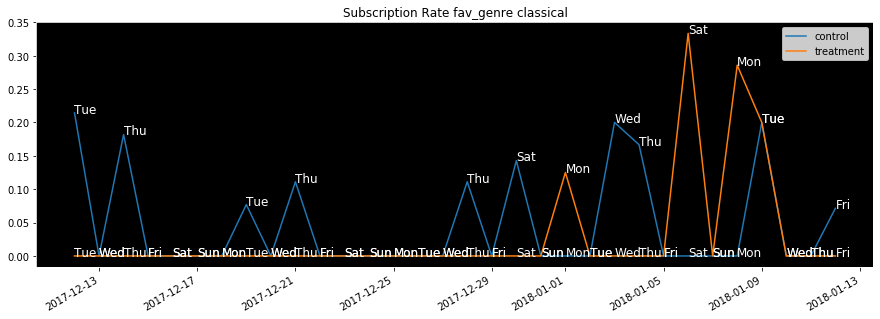

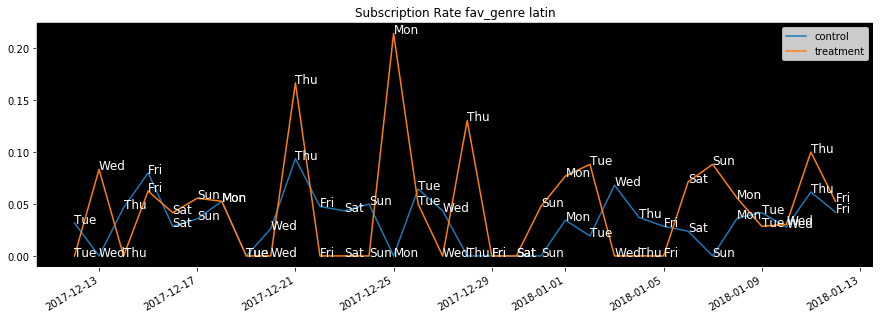

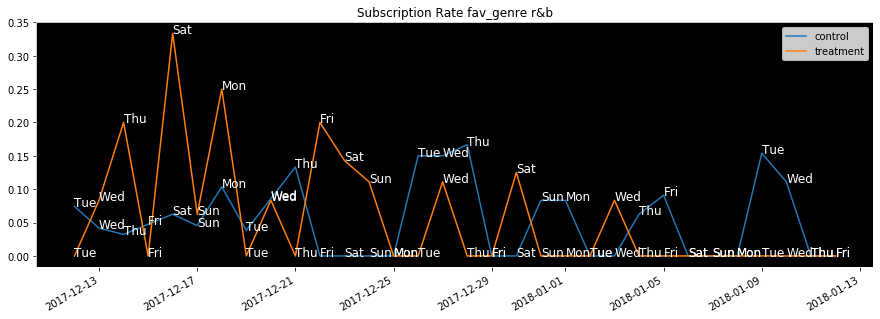

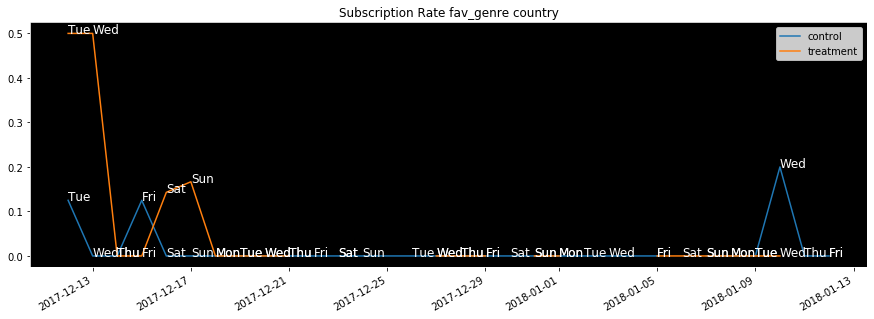

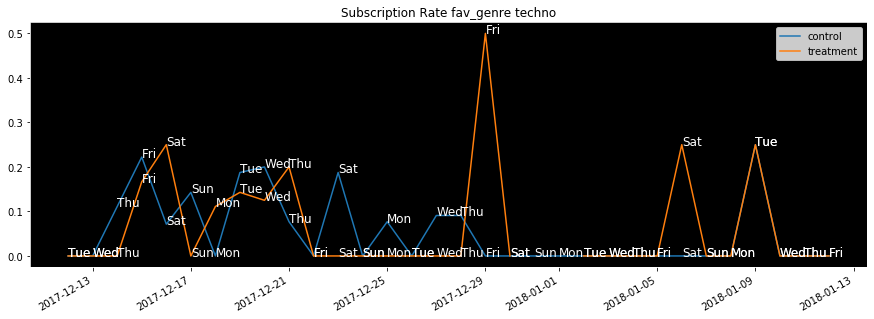

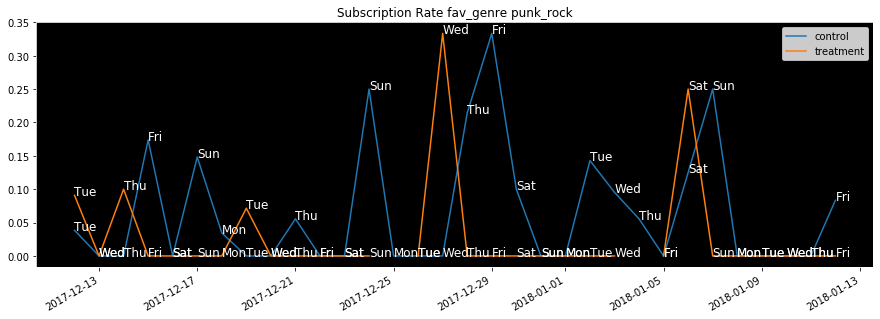

In [34]:
group_by(df,'fav_genre')

In [35]:
## deep dive
df[(df['fav_genre'] == 'classical')&(df['variant_id'] == 1)].groupby(['click_date','subscriber']).size()

click_date  subscriber
2017-12-12  0             10
2017-12-13  0              8
2017-12-14  0              5
2017-12-15  0              2
2017-12-16  0              4
2017-12-17  0              8
2017-12-18  0              2
2017-12-19  0              6
2017-12-20  0              7
2017-12-21  0              3
2017-12-22  0              2
2017-12-23  0              6
2017-12-24  0              1
2017-12-25  0              4
2017-12-26  0              3
2017-12-27  0              2
2017-12-28  0              4
2017-12-29  0              1
2017-12-30  0              2
2017-12-31  0              2
2018-01-01  0              7
            1              1
2018-01-02  0              3
2018-01-03  0              3
2018-01-04  0              2
2018-01-05  0              3
2018-01-06  0              2
            1              1
2018-01-07  0              1
2018-01-08  0              5
            1              2
2018-01-09  0              4
            1              1
2018-01-10  0       

Classical favorites are converting at a later time.

### Trend by category

#### Build a tree for control group

In [112]:
df['month'] = df['click_date'].dt.month
df['weekday'] = df['click_date'].dt.weekday

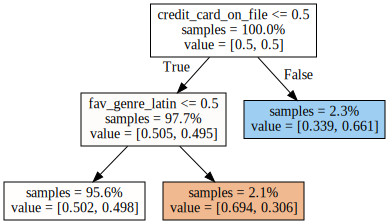

In [124]:
## remove customer_state
df_model = df.drop(['customer_id','click_date','customer_city','customer_state'], axis=1)
df_dummy = pd.get_dummies(df_model)
df_dummy_control = df_dummy[df_dummy['variant_id'] == 0]

train_control = df_dummy_control.drop(['subscriber', 'variant_id'], axis=1)

clf = DecisionTreeClassifier(
    class_weight="balanced", 
    min_impurity_decrease = 0.001
    )
clf.fit(train_control,df_dummy_control['subscriber'])

# Visualize the Tree on notebook
export_graphviz(clf, out_file = './tree2.dot', feature_names=train_control.columns, impurity = False, proportion=True, filled=True)
s = Source.from_file("./tree2.dot")
s

In [114]:
#feature importance
pd.Series(clf.feature_importances_,index = train_control.columns).sort_values(ascending=False).head(5)

credit_card_on_file            0.601663
fav_genre_latin                0.398337
fav_genre_techno               0.000000
platform_undefined platform    0.000000
student                        0.000000
dtype: float64

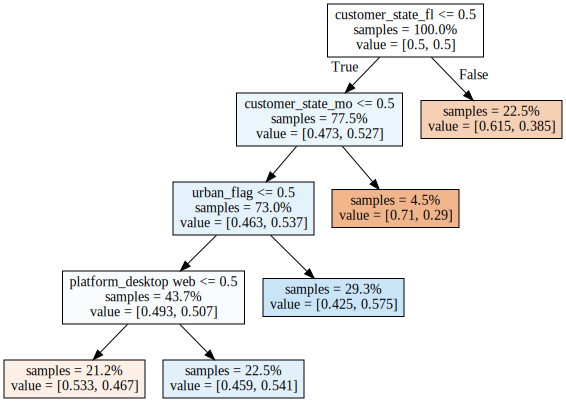

In [115]:
## not remove customer_state
df_model = df.drop(['customer_id','click_date','customer_city'], axis=1)
df_dummy = pd.get_dummies(df_model)
df_dummy_control = df_dummy[df_dummy['variant_id'] == 0]

train_control = df_dummy_control.drop(['subscriber', 'variant_id'], axis=1)

clf = DecisionTreeClassifier(
    class_weight="balanced", 
    min_impurity_decrease = 0.001
    )
clf.fit(train_control,df_dummy_control['subscriber'])

# Visualize the Tree on notebook
export_graphviz(clf, out_file = './tree3.dot', feature_names=train_control.columns, impurity = False, proportion=True, filled=True)
s = Source.from_file("./tree3.dot")
s

In [40]:
# feature importance
pd.Series(clf.feature_importances_,index = train_control.columns).sort_values(ascending=False).head(5)

customer_state_fl       0.473872
customer_state_mo       0.297252
urban_flag              0.135577
platform_desktop web    0.093299
customer_state_hi       0.000000
dtype: float64

#### Build a tree for treatment group

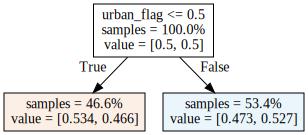

In [117]:
# remove customer_state
df_model = df.drop(['customer_id','click_date','customer_city','customer_state'], axis=1)
df_dummy = pd.get_dummies(df_model)
df_dummy_treatment = df_dummy[df_dummy['variant_id'] == 1]

train_treatment = df_dummy_treatment.drop(['subscriber', 'variant_id'], axis=1)

clf = DecisionTreeClassifier(
    class_weight="balanced", 
    min_impurity_decrease = 0.001
    )
clf.fit(train_treatment,df_dummy_treatment['subscriber'])

# Visualize the Tree on notebook
export_graphviz(clf, out_file = './tree4.dot', feature_names=train_treatment.columns, proportion=True,impurity = False, filled=True)
s = Source.from_file("./tree4.dot")
s

In [43]:
pd.Series(clf.feature_importances_,index = train_treatment.columns).sort_values(ascending=False).head(5)

urban_flag                     1.0
platform_undefined platform    0.0
credit_card_on_file            0.0
student                        0.0
month                          0.0
dtype: float64

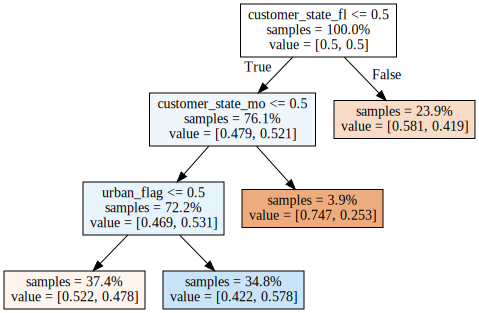

In [119]:
# not remove customer_state
df_model = df.drop(['customer_id','click_date','customer_city'], axis=1)
df_dummy = pd.get_dummies(df_model)
df_dummy_treatment = df_dummy[df_dummy['variant_id'] == 1]

train_treatment = df_dummy_treatment.drop(['subscriber', 'variant_id'], axis=1)

clf = DecisionTreeClassifier(
    class_weight="balanced", 
    min_impurity_decrease = 0.001
    )
clf.fit(train_treatment,df_dummy_treatment['subscriber'])

# Visualize the Tree on notebook
export_graphviz(clf, out_file = './tree5.dot', feature_names=train_treatment.columns, proportion=True,impurity = False, filled=True)
s = Source.from_file("./tree5.dot")
s

In [45]:
pd.Series(clf.feature_importances_,index = train_treatment.columns).sort_values(ascending=False).head(5)

customer_state_mo    0.357572
urban_flag           0.336871
customer_state_fl    0.305557
customer_state_ca    0.000000
customer_state_ky    0.000000
dtype: float64

In [46]:
def plot_conversion_bar(df,col):
    df_slice = pd.DataFrame(columns = [col,'control','treatment'])
    for i in df[col].sort_values().unique():
        control = np.mean(df[(df.variant_id == 0) & (df[col] == i)].subscriber)
        treatment = np.mean(df[(df.variant_id == 1) & (df[col] == i)].subscriber)
        dict_ = {col:[i],
        'control':[control],
        'treatment':[treatment]
       }
        df_slice = pd.concat([df_slice,pd.DataFrame(dict_)],ignore_index = True)
    ax = plt.gca()
    df_slice.plot(kind = 'bar', x = col, ax=ax, figsize= (15,5))

    ax.set_facecolor('xkcd:black')
#     ax.yaxis.label.set_color('white')
#     ax.xaxis.label.set_color('white')
#     ax.title.set_color('white')
#     ax.xdate.set_color('white')
    ax.title.set_text(f'Subscription rate by {col}')
#     ax.tick_params(axis='x', colors='white')
#     ax.tick_params(axis='y', colors='white')
    ax.spines['bottom'].set_color('white')
    ax.spines['top'].set_color('white') 
    ax.spines['right'].set_color('white')
    ax.spines['left'].set_color('white')
#     df_slice.plot(kind = 'bar',x= col,y = 'treatment',color = 'red', ax=ax)


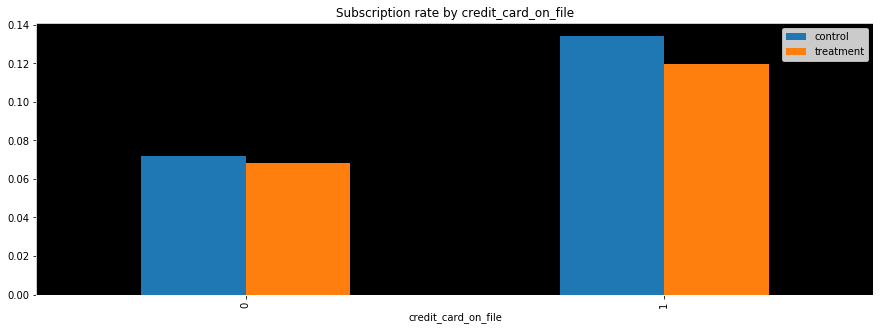

In [47]:
plot_conversion_bar(df,'credit_card_on_file')

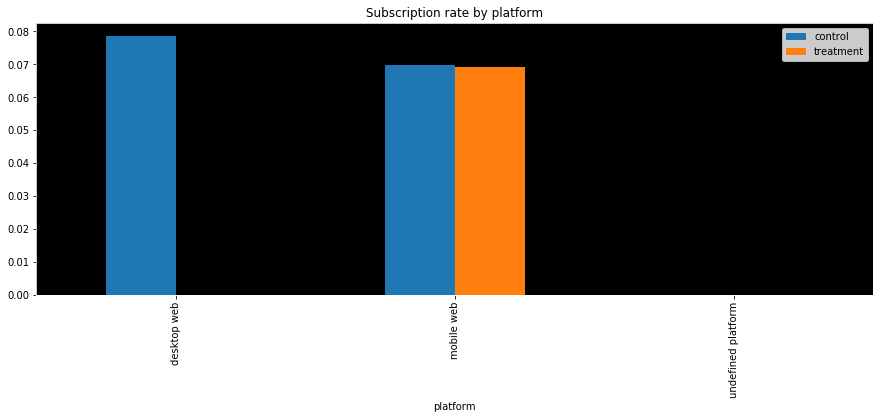

In [48]:
plot_conversion_bar(df,'platform')

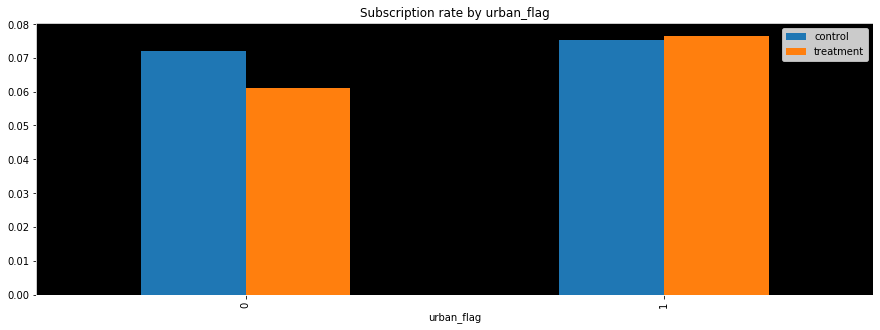

In [49]:
plot_conversion_bar(df,'urban_flag')

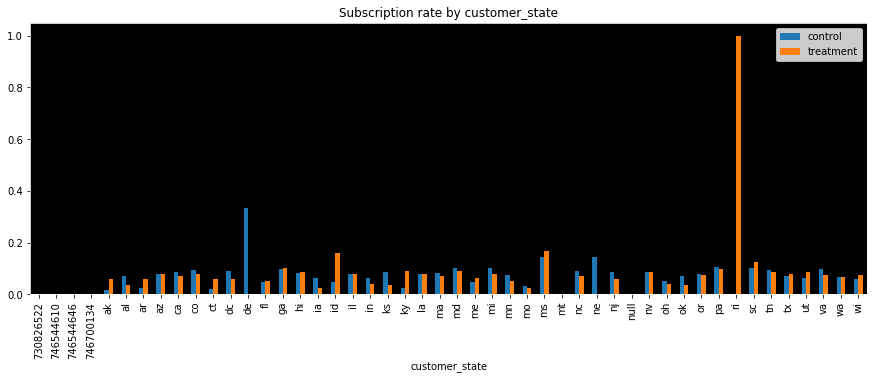

In [50]:
plot_conversion_bar(df,'customer_state')

In [52]:
df[df.customer_state == 'fl'].groupby(['subscriber']).size()

subscriber
0    20641
1     1058
dtype: int64

In [53]:
df[df.customer_state == 'mo'].groupby(['subscriber']).size()

subscriber
0    3889
1     117
dtype: int64

In [54]:
df[df.customer_state == 'ri'].groupby(['subscriber']).size()

subscriber
0    19
1     2
dtype: int64

In [55]:
df[df.customer_state == 'de'].groupby(['subscriber']).size()

subscriber
0    6
1    1
dtype: int64

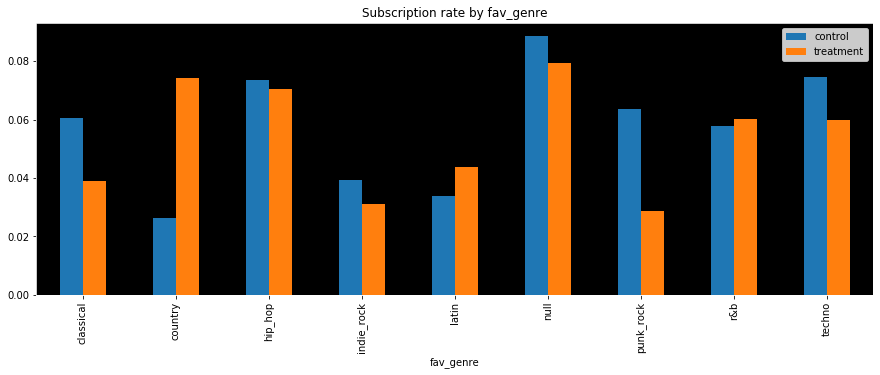

In [120]:
plot_conversion_bar(df,'fav_genre')

## A/B test results

### Sanity check

In [56]:
## check for mixed assignments
users_control = set(df[df['variant_id']==0]['customer_id'])
users_treatment = set(df[df['variant_id']==1]['customer_id'])

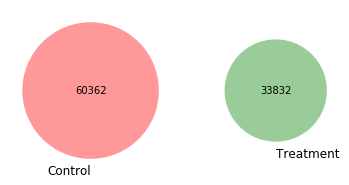

In [57]:
venn2(subsets = (len(users_control - users_treatment), len(users_treatment - users_control), len(users_control & users_treatment)), set_labels = ('Control', 'Treatment'))


no mixed assignments

In [58]:
print(df.click_date.min()) ## check duration
print(df.click_date.max())

2017-12-12 00:00:00
2018-01-12 00:00:00


#### Build a tree to check randomization

In [61]:
df_model = df.drop(['customer_id','click_date'], axis=1)
df_dummy = pd.get_dummies(df_model)
#model features, test is the label and conversion is not needed here
train = df_dummy.drop(['subscriber', 'variant_id'], axis=1)
test = df_dummy['variant_id']
  
clf = DecisionTreeClassifier(
    class_weight="balanced", min_impurity_decrease = 0.001
    )
clf.fit(train,test)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.001, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [62]:
clf.decision_path

<bound method BaseDecisionTree.decision_path of DecisionTreeClassifier(class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.001, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')>

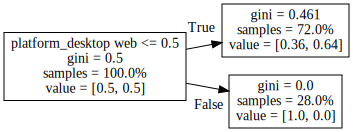

In [63]:
export_graphviz(clf, out_file="./tree.dot", feature_names=train.columns, proportion=True, rotate=True)
s = Source.from_file("./tree.dot")
s

In [64]:
print(df.groupby(['variant_id','platform']).size())

variant_id  platform          
0           desktop web           26394
            mobile web            33967
            undefined platform        1
1           mobile web            33830
            undefined platform        2
dtype: int64


Since desktop web does not exist in treatment group, we should remove them in control group.

In [65]:
df = df[(df.platform == 'mobile web')]
df.groupby(['variant_id','platform']).size()

variant_id  platform  
0           mobile web    33967
1           mobile web    33830
dtype: int64

In [66]:
##sample ratio match
control = df[df['variant_id']==0].shape[0]
treatment = df[df['variant_id']==1].shape[0]
sd = np.sqrt((control+treatment)*0.5*0.5)
true = (control+treatment)*0.5
ci = [true - 1.96*sd,true + 1.96*sd]
if control >= ci[0] and control <= ci[1]:
    print('Sanity check pass!')
else:
    print('Sanity check doesn\'t pass')

Sanity check pass!


### Check sample size

In [67]:
df[df['variant_id']==0].describe()

customer_id    urban_flag  credit_card_on_file       student  \
count  3.396700e+04  33967.000000         33967.000000  33967.000000   
mean   1.042838e+09      0.527365             0.018871      0.302617   
std    2.722353e+04      0.499258             0.136072      0.459398   
min    1.042791e+09      0.000000             0.000000      0.000000   
25%    1.042815e+09      0.000000             0.000000      0.000000   
50%    1.042839e+09      1.000000             0.000000      0.000000   
75%    1.042862e+09      1.000000             0.000000      1.000000   
max    1.042885e+09      1.000000             1.000000      1.000000   

         subscriber  variant_id         month       weekday  
count  33967.000000     33967.0  33967.000000  33967.000000  
mean       0.069685         0.0      8.505726      2.931551  
std        0.254620         0.0      5.121312      1.888098  
min        0.000000         0.0      1.000000      0.000000  
25%        0.000000         0.0      1.000000      1.000000  
50%        0.000000         0.0     12.000000      3.000000  
75%        0.000000         0.0     12.000000      4.000000  
max        1.000000         0.0     12.000000      6.000000

In [70]:
import statsmodels.stats.api as sms

p1_and_p2 = sms.proportion_effectsize(0.070, 0.080)#suppose the min detectable change is 1%

sample_size = sms.NormalIndPower().solve_power(p1_and_p2, power=0.8, alpha=0.05)
print("The required sample size per group is:", round(sample_size))

The required sample size per group is: 10879


In [71]:
df.groupby('variant_id').size()

variant_id
0    33967
1    33830
dtype: int64

We have enough sample for the experiment.

##### The following plots are just used to eyeball/review the distribution since the tree has already told us the test is randomized except for platform.

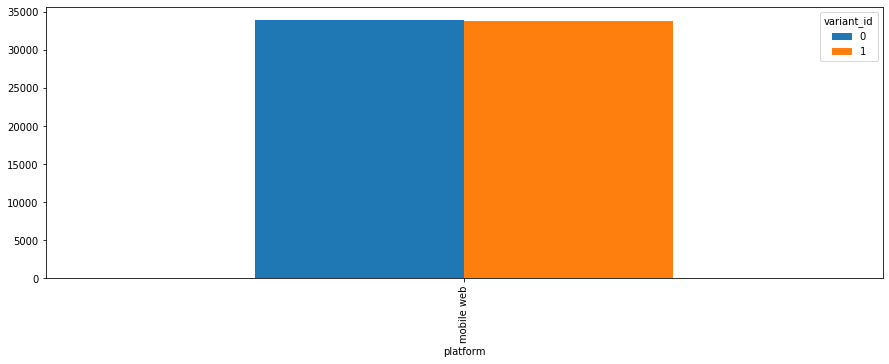

In [72]:
df.groupby(['platform','variant_id']).size().unstack(fill_value=0).plot(kind='bar',figsize = (15,5))
plt.show()

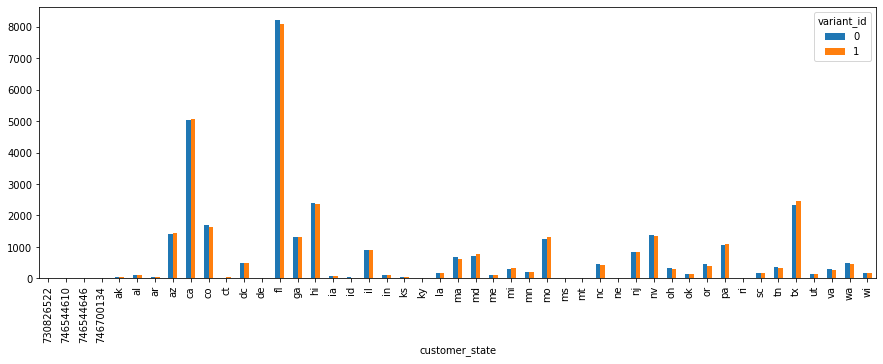

In [73]:
df.groupby(['customer_state','variant_id']).size().unstack(fill_value=0).plot(kind='bar',figsize = (15,5))
plt.show()

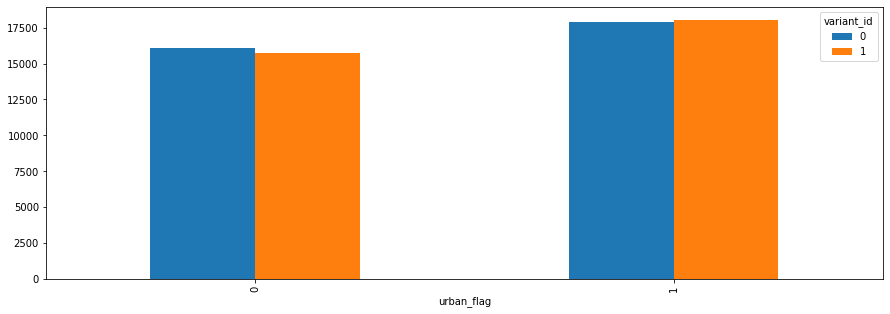

In [74]:
df.groupby(['urban_flag','variant_id']).size().unstack(fill_value=0).plot(kind='bar',figsize = (15,5))
plt.show()

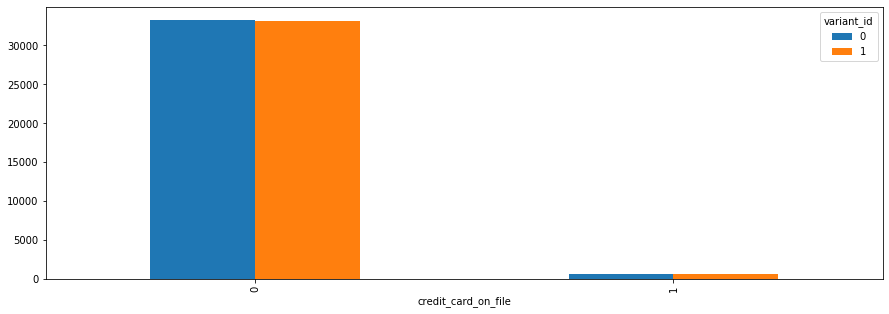

In [75]:
df.groupby(['credit_card_on_file','variant_id']).size().unstack(fill_value=0).plot(kind='bar',figsize = (15,5))
plt.show()

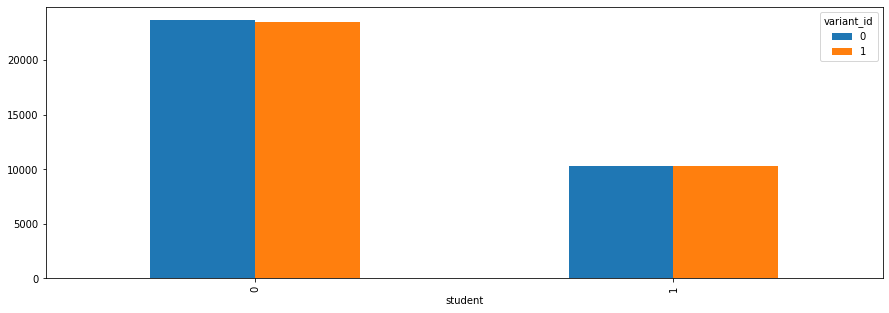

In [76]:
df.groupby(['student','variant_id']).size().unstack(fill_value=0).plot(kind='bar',figsize = (15,5))
plt.show()

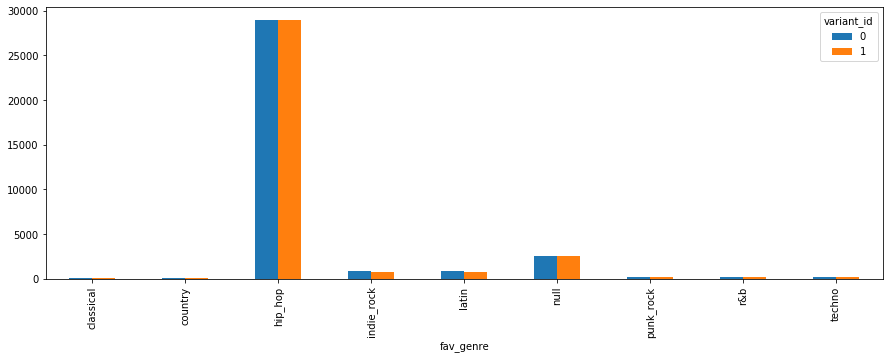

In [77]:
df.groupby(['fav_genre','variant_id']).size().unstack(fill_value=0).plot(kind='bar',figsize = (15,5))
plt.show()

### Hypothesis testing

In [79]:
users_t = df[df.variant_id == 1].shape[0]
users_c = df[df.variant_id == 0].shape[0]
subs_t = df[(df.variant_id == 1) & (df.subscriber == 1)].shape[0]
subs_c = df[(df.variant_id == 0) & (df.subscriber == 1)].shape[0]
print('subscription rate for control group:', subs_c/users_c)
print('subscription rate for treat group:', subs_t/users_t)


subscription rate for control group: 0.06968528277445757
subscription rate for treat group: 0.06928761454330476


In [80]:
subscriptions = np.array([subs_c, subs_t])
users = np.array([users_c, users_t])

zscore, pvalue = proportions_ztest(subscriptions, users, alternative = 'two-sided')
print('zscore = {:.4f}, pvalue = {:.4f}'.format(zscore, pvalue))

zscore = 0.2036, pvalue = 0.8387


The p value is larger than 0.05, it is not statistically significant at all.

In [81]:
def slicing(df,col,val):
    users_t = df[(df.variant_id == 1)&(df[col] == val)].shape[0]
    users_c = df[(df.variant_id == 0)&(df[col] == val)].shape[0]
    subs_t = df[(df.variant_id == 1) & (df.subscriber == True) & (df[col] == val)].shape[0]
    subs_c = df[(df.variant_id == 0) & (df.subscriber == True) & (df[col] == val)].shape[0]
    
    subscriptions = np.array([subs_c, subs_t])
    users = np.array([users_c, users_t])
    zscore, pvalue = proportions_ztest(subscriptions, users, alternative = 'two-sided')
    return zscore, pvalue

In [82]:
def slice_df(df,col):
    df_slice = pd.DataFrame(columns = [col,'Z Score','P Value'])
    for i in df[col].sort_values().unique():
        zscore, pvalue = slicing(df,col,i)
        dict_ = {col:[i],
        'Z Score':[zscore],
        'P Value':[pvalue]
       }
        df_slice = pd.concat([df_slice,pd.DataFrame(dict_)],ignore_index = True)
    df_slice['Statistically significant'] = np.where(df_slice['P Value'] < 0.05,True, False)
    return df_slice

In [83]:
def slice_conversion(df,col):
    df_slice = pd.DataFrame(columns = [col,'Control','Treatment','T-Subscriber','T-User'])

    for i in df[col].sort_values().unique():
        control = np.mean(df[(df.variant_id == 0) & (df[col] == i)].subscriber)
        treatment = np.mean(df[(df.variant_id == 1) & (df[col] == i)].subscriber)
        treatment_sub = df[(df.variant_id == 1) & (df[col] == i) & (df.subscriber == 1)].shape[0]
        treatment_user = df[(df.variant_id == 1) & (df[col] == i)].shape[0]
        dict_ = {col:[i],
        'Control':[control],
        'Treatment':[treatment],
        'T-Subscriber':[treatment_sub],
        'T-User':[treatment_user]
       }
        df_slice = pd.concat([df_slice,pd.DataFrame(dict_)],ignore_index = True)
        df_slice['Treatment/Control'] = df_slice['Treatment']/df_slice['Control']
    return df_slice

In [84]:
## slice by day
slice_by_day = slice_df(df,'click_date')
date_conversion = slice_conversion(df,'click_date')
result_date =pd.merge(slice_by_day[slice_by_day['Statistically significant'] == True],date_conversion,on='click_date',how='left')[['click_date','Statistically significant', 'Control',  'Treatment', 'Treatment/Control','T-Subscriber','T-User']].rename({'click_date':'Click Date'},axis = 1)


In [85]:
result_date

Click Date  Statistically significant   Control  Treatment  \
0 2017-12-14                       True  0.087652   0.065562   
1 2017-12-19                       True  0.086614   0.063165   
2 2017-12-22                       True  0.067669   0.092873   

   Treatment/Control T-Subscriber T-User  
0           0.747976           91   1388  
1           0.729273           89   1409  
2           1.372450          129   1389

In [86]:
## slice by state
slice_by_state = slice_df(df,'customer_state')
state_conversion = slice_conversion(df,'customer_state')
result_state =pd.merge(slice_by_state[slice_by_state['Statistically significant'] == True],state_conversion,on='customer_state',how='left')[['customer_state','Statistically significant', 'Control',  'Treatment', 'Treatment/Control','T-Subscriber','T-User']].rename({'customer_state':'Customer State'},axis = 1)

In [87]:
result_state

Customer State  Statistically significant  Control  Treatment  \
0             id                       True      0.0       0.16   
1             ri                       True      0.0       1.00   

   Treatment/Control T-Subscriber T-User  
0                inf            4     25  
1                inf            2      2

In [88]:
## slice by urban
slice_by_urban = slice_df(df,'urban_flag')
slice_by_urban

urban_flag   Z Score   P Value  Statistically significant
0          0  0.010338  0.991751                      False
1          1  0.328843  0.742275                      False

In [89]:
## slice by card
slice_by_card = slice_df(df,'credit_card_on_file')
slice_by_card

credit_card_on_file   Z Score   P Value  Statistically significant
0                   0  0.152923  0.878459                      False
1                   1  0.289621  0.772106                      False

In [90]:
## slice by student
slice_by_student = slice_df(df,'student')
slice_by_student

student   Z Score   P Value  Statistically significant
0       0 -0.271090  0.786322                      False
1       1  0.768983  0.441903                      False

In [91]:
## slice by genre
slice_by_genre = slice_df(df,'fav_genre')
genre_conversion = slice_conversion(df,'fav_genre')
result_genre =pd.merge(slice_by_genre[slice_by_genre['Statistically significant'] == True],genre_conversion,on='fav_genre',how='left')[['fav_genre','Statistically significant', 'Control',  'Treatment', 'Treatment/Control','T-Subscriber','T-User']].rename({'fav_genre':'Fav Genre'},axis = 1)

In [92]:
result_genre

Fav Genre  Statistically significant   Control  Treatment  \
0     latin                       True  0.025767    0.04375   

   Treatment/Control T-Subscriber T-User  
0           1.697917           35    800